In [9]:
# This is my final project. I have included all milestones into this google collab.

In [10]:
# I was having issues with jupyter notebook to run last section (patent section) then I switched to google colab.

In [ ]:
# I still need to enhance the deployment to hugging space. You can check here: https://huggingface.co/spaces/alguillen08/TextSentimentAnalyzer

In [ ]:
# There are a lot of areas of improvement.

### Week 1 ( This is from a jupyter notebook). Google Colab does not support Docker

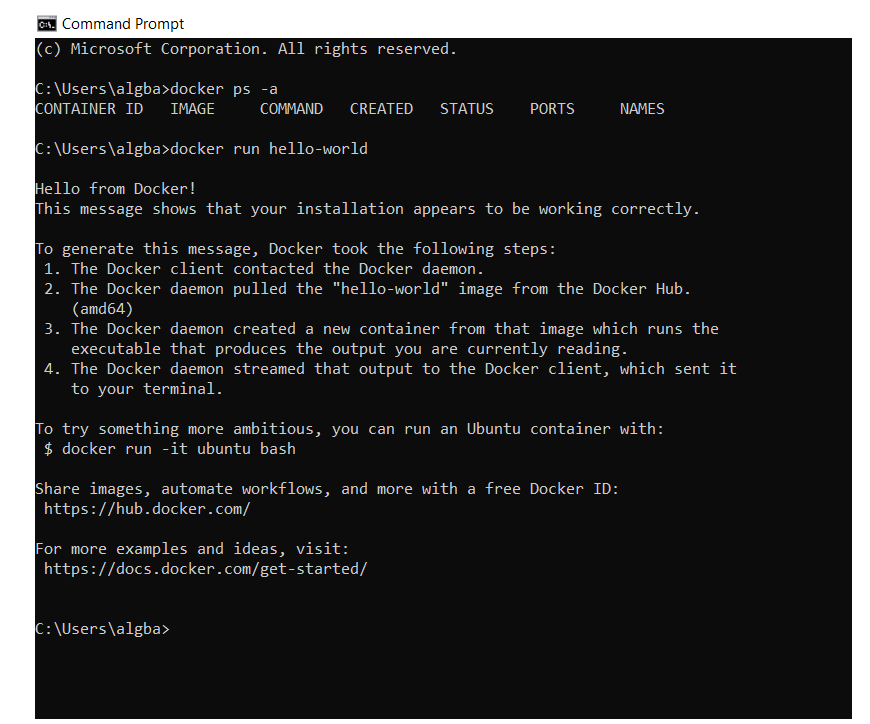
Detailed Steps in Function
Run the Container:

The function uses the client.containers.run method to run the hello-world container. Running in detached mode allows the function to continue executing without waiting for the container to finish.
Retrieve Logs:

The container.logs() method fetches the logs generated by the container. These logs contain the "Hello from Docker!" message.
Remove the Container:

The container.remove() method removes the container instance to free up resources.
Decode and Return Logs:

The logs are decoded from bytes to a UTF-8 string and returned by the function.

### This is code in Jupyter Notebook
 #### Step 1: Install Docker SDK for Python with --user option (Run this cell only once)
 !pip install docker --user

 #### Step 2: Import Docker SDK
import docker

 #### Step 3: Connect to Docker
client = docker.from_env()

 #### Step 4: Run a Hello World Container
def run_hello_world():
    container = client.containers.run("hello-world", detach=True)
    logs = container.logs()
    container.remove()
    return logs.decode("utf-8")

output = run_hello_world()
print(output)


### Week 2

In [ ]:
# !pip install streamlit transformers torch

### Create the Streamlit App

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import pipeline

Run this section, and code will output interface. In the text section, add sentence and click Analyze sentiment

In [7]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import pipeline

# Define the Sentiment Analysis Function
def analyze_sentiment(b):
    with output_area:
        clear_output()
        print("Button clicked!")  # Debugging statement
        if text_input.value:
            print("Text input detected.")  # Debugging statement
            classifier = pipeline('sentiment-analysis', model=model_selector.value)
            result = classifier(text_input.value)
            print("Sentiment Analysis Result:")
            print(result)
        else:
            print("Please enter text to analyze.")  # Debugging statement

# Text input for user to enter the text
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text for sentiment analysis',
    description='Text:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='100px')
)

# Dropdown menu for selecting the pretrained model
model_selector = widgets.Dropdown(
    options=[
        ('DistilBERT (English)', 'distilbert-base-uncased-finetuned-sst-2-english'),
        ('BERT (Multilingual)', 'nlptown/bert-base-multilingual-uncased-sentiment')
    ],
    value='distilbert-base-uncased-finetuned-sst-2-english',
    description='Model:'
)

# Button to perform sentiment analysis
analyze_button = widgets.Button(
    description='Analyze Sentiment',
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to analyze sentiment',
    icon='check'
)

# Output area to display the results
output_area = widgets.Output()

# Link the button to the function
analyze_button.on_click(analyze_sentiment)
print("Button linked!")  # Debugging statement

# Display widgets
display(text_input, model_selector, analyze_button, output_area)


Button linked!


Textarea(value='', description='Text:', layout=Layout(height='100px', width='100%'), placeholder='Enter text f…

Dropdown(description='Model:', options=(('DistilBERT (English)', 'distilbert-base-uncased-finetuned-sst-2-engl…

Button(button_style='success', description='Analyze Sentiment', icon='check', style=ButtonStyle(), tooltip='Cl…

Output()

### Deployment ( I am still trouble shooting this step. There are some dependencies that are not clear and I am trying to figure out). I have created my account and create new space for deployment

This is the link: https://huggingface.co/spaces/alguillen08/TextSentimentAnalyzer

In [3]:
#### Creating app.py (Streamlit)

In [7]:
### Access and test deployed app

https://huggingface.co/spaces/alguillen08/TextSentimentAnalyzer

In [ ]:
#### Trouble-shootiing
I still need to troubleshoot the deployment

### FineTunning

In [1]:
# !pip install transformers datasets ipywidgets

In [ ]:
# Load the Fine-Tuned model

In [2]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict

# Load the dataset from HuggingFace with the 'sample' configuration and specify dates
dataset = load_dataset("HUPD/hupd", "sample", train_filing_start_date="2016-01-01", train_filing_end_date="2016-01-15", val_filing_start_date="2016-01-16", val_filing_end_date="2016-01-31")

# Convert the date column to datetime format and filter for January 2016
dataset_df = dataset['train'].to_pandas()
dataset_df['filing_date'] = pd.to_datetime(dataset_df['filing_date'])
jan_2016_df = dataset_df[(dataset_df['filing_date'].dt.year == 2016) & (dataset_df['filing_date'].dt.month == 1)]

# Check unique values in the decision column
print(jan_2016_df['decision'].unique())

# Filter out 'PENDING' cases
jan_2016_df = jan_2016_df[jan_2016_df['decision'].isin(['ACCEPTED', 'REJECTED'])]

# Use a small subset for fine-tuning
small_subset_df = jan_2016_df.sample(n=100)  # Adjust the number as needed

# Update the label mapping to include all possible values
label_mapping = {'ACCEPTED': 1, 'REJECTED': 0}

# Map the 'decision' column to numerical labels
small_subset_df['labels'] = small_subset_df['decision'].map(label_mapping)

# Convert the dataframe back to a HuggingFace dataset
small_subset_dataset = DatasetDict({"train": Dataset.from_pandas(small_subset_df)})

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the dataset, using the 'abstract' column for text data
def tokenize_function(examples):
    return tokenizer(examples["abstract"], padding="max_length", truncation=True)

tokenized_datasets = small_subset_dataset.map(tokenize_function, batched=True)

# Ensure labels are correctly added during tokenization
def add_labels(examples):
    examples["labels"] = [label_mapping[decision] for decision in examples["decision"]]
    return examples

tokenized_datasets = tokenized_datasets.map(add_labels, batched=True)

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Updated to 'eval_strategy'
    logging_dir='./logs',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["train"],  # Using the same subset for evaluation as well
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

print("Fine-tuning completed and model saved.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for HUPD/hupd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/HUPD/hupd.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
Loading dataset with config: PatentsConfig(name='sample', version=0.0.0, data_dir='sample', data_files=None, description='Patent data from January 2016, for debugging')


Using metadata file: /root/.cache/huggingface/datasets/downloads/bac34b767c2799633010fa78ecd401d2eeffd62eff58abdb4db75829f8932710


Reading metadata file: /root/.cache/huggingface/datasets/downloads/bac34b767c2799633010fa78ecd401d2eeffd62eff58abdb4db75829f8932710
Filtering train dataset by filing start date: 2016-01-01
Filtering train dataset by filing end date: 2016-01-15
Filtering val dataset by filing start date: 2016-01-16
Filtering val dataset by filing end date: 2016-01-31


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

['ACCEPTED' 'PENDING' 'REJECTED']


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.519022
2,No log,0.475689
3,No log,0.468363


Fine-tuning completed and model saved.


In [ ]:
# Load the Fine-Tuned Model

In [3]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine-tuned-model")
tokenizer = AutoTokenizer.from_pretrained("./fine-tuned-model")

# Create a pipeline for sentiment analysis
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Test the classifier on a sample text
sample_text = "This is an example patent abstract to test the model."
result = classifier(sample_text)
print(result)


[{'label': 'LABEL_1', 'score': 0.6880998015403748}]


In [ ]:
# Evaluate Model

In [4]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")


Evaluation Results: {'eval_loss': 0.4683625102043152, 'eval_runtime': 103.152, 'eval_samples_per_second': 0.969, 'eval_steps_per_second': 0.068, 'epoch': 3.0}


In [5]:
# Save Model and Tokenizer

In [ ]:
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

('./fine-tuned-model/tokenizer_config.json',
 './fine-tuned-model/special_tokens_map.json',
 './fine-tuned-model/vocab.txt',
 './fine-tuned-model/added_tokens.json',
 './fine-tuned-model/tokenizer.json')

In [ ]:
## Modifying app

In [ ]:
# Code needs to revised in order to detect Non-Patentable (Future Work)

# Future work will include:
# 1. Check training data balance
# 2. Review the training process
# 3. Test with more diverse exasmples

In [6]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict

# Load the dataset from Hugging Face
dataset = load_dataset("HUPD/hupd", "sample", train_filing_start_date="2016-01-01", train_filing_end_date="2016-01-15", val_filing_start_date="2016-01-16", val_filing_end_date="2016-01-31")

# Convert the date column to datetime format and filter for January 2016
dataset_df = dataset['train'].to_pandas()
dataset_df['filing_date'] = pd.to_datetime(dataset_df['filing_date'])
jan_2016_df = dataset_df[(dataset_df['filing_date'].dt.year == 2016) & (dataset_df['filing_date'].dt.month == 1)]

# Filter out 'PENDING' cases
jan_2016_df = jan_2016_df[jan_2016_df['decision'].isin(['ACCEPTED', 'REJECTED'])]

# Use a small subset for the app
small_subset_df = jan_2016_df.sample(n=100)  # Adjust the number as needed

# Convert the dataframe to a dictionary for easy lookup
patent_data = small_subset_df.set_index('patent_number')[['abstract', 'claims']].to_dict('index')

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine-tuned-model")
tokenizer = AutoTokenizer.from_pretrained("./fine-tuned-model")

# Create a pipeline for sentiment analysis
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Define the function to retrieve patent sections based on the selected filing number
def retrieve_patent_sections(change):
    filing_number = filing_selector.value
    if filing_number:
        patent_sections = patent_data.get(filing_number, {})
        abstract_text.value = patent_sections.get('abstract', 'N/A')
        claims_text.value = patent_sections.get('claims', 'N/A')

# Define the Sentiment Analysis Function
def analyze_sentiment(b):
    with output_area:
        clear_output()
        if abstract_text.value and claims_text.value:
            abstract_result = classifier(abstract_text.value[:512])
            claims_result = classifier(claims_text.value[:512])
            label_mapping = {"LABEL_1": "Patentable", "LABEL_0": "Not Patentable"}
            abstract_display = {
                "label": label_mapping.get(abstract_result[0]['label'], "Unknown"),
                "score": abstract_result[0]['score']
            }
            claims_display = {
                "label": label_mapping.get(claims_result[0]['label'], "Unknown"),
                "score": claims_result[0]['score']
            }
            print("Patentability Score (Abstract):")
            print(abstract_display)
            print("Patentability Score (Claims):")
            print(claims_display)
        else:
            print("Please enter text to analyze.")

# Dropdown menu for selecting the application filing number
filing_selector = widgets.Dropdown(
    options=[('', '')] + [(str(key), str(key)) for key in patent_data.keys()],
    value='',
    description='Filing No:'
)

# Link the dropdown to the function to retrieve patent sections
filing_selector.observe(retrieve_patent_sections, names='value')

# Text input for user to enter the abstract
abstract_text = widgets.Textarea(
    value='',
    placeholder='Abstract will be displayed here',
    description='Abstract:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='100px')
)

# Text input for user to enter the claims
claims_text = widgets.Textarea(
    value='',
    placeholder='Claims will be displayed here',
    description='Claims:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='100px')
)

# Button to perform sentiment analysis
analyze_button = widgets.Button(
    description='Analyze Sentiment',
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to analyze sentiment',
    icon='check'
)

# Output area to display the results
output_area = widgets.Output()

# Link the button to the function
analyze_button.on_click(analyze_sentiment)

# Display widgets
display(filing_selector, abstract_text, claims_text, analyze_button, output_area)


Dropdown(description='Filing No:', options=(('', ''), ('14990641', '14990641'), ('14903066', '14903066'), ('14…

Textarea(value='', description='Abstract:', layout=Layout(height='100px', width='100%'), placeholder='Abstract…

Textarea(value='', description='Claims:', layout=Layout(height='100px', width='100%'), placeholder='Claims wil…

Button(button_style='success', description='Analyze Sentiment', icon='check', style=ButtonStyle(), tooltip='Cl…

Output()